In [2]:
import cv2
import numpy as np
import imutils
import os
import shutil
from matplotlib import pyplot as plt
from IPython.display import Image 
from PIL import Image        
from types import SimpleNamespace
import random as rng
from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
import pprint
import itertools as it
from scipy.interpolate import splprep, splev

rng.seed(12345)
pp = pprint.PrettyPrinter(indent=4)

In [70]:
file_ready_for_lines_detection = os.path.join(os.path.dirname(os.path.realpath("__file__")),"phase0-output/processed/88d1c53a-4933-55ab-9223-3d14f4d87a07-e6722290_pg-0_sg-0_M.jpg")
# input_file = os.path.join(os.path.dirname(os.path.realpath("__file__")),"phase0-output/processed/b2432346-2637-5e69-a752-128f71c1bb44-1d8625b3_pg-0_sg-0_M.jpg")
# input_file = os.path.join(os.path.dirname(os.path.realpath("__file__")),"phase0-output/processed/b2432346-2637-5e69-a752-128f71c1bb44-e2455027_pg-1_sg-0_M.jpg")
# input_file = os.path.join(os.path.dirname(os.path.realpath("__file__")),"phase0-output/processed/88d1c53a-4933-55ab-9223-3d14f4d87a07-e6722290_pg-0_sg-0_M.jpg")
input_file = os.path.join(os.path.dirname(os.path.realpath("__file__")),"phase0-output/processed/88d1c53a-4933-55ab-9223-3d14f4d87a07-e2993783_pg-2_sg-0_M.jpg")
# input_file = os.path.join(os.path.dirname(os.path.realpath("__file__")),"phase0-output/processed/88d1c53a-4933-55ab-9223-3d14f4d87a07-6231e166_pg-1_sg-0_M.jpg")

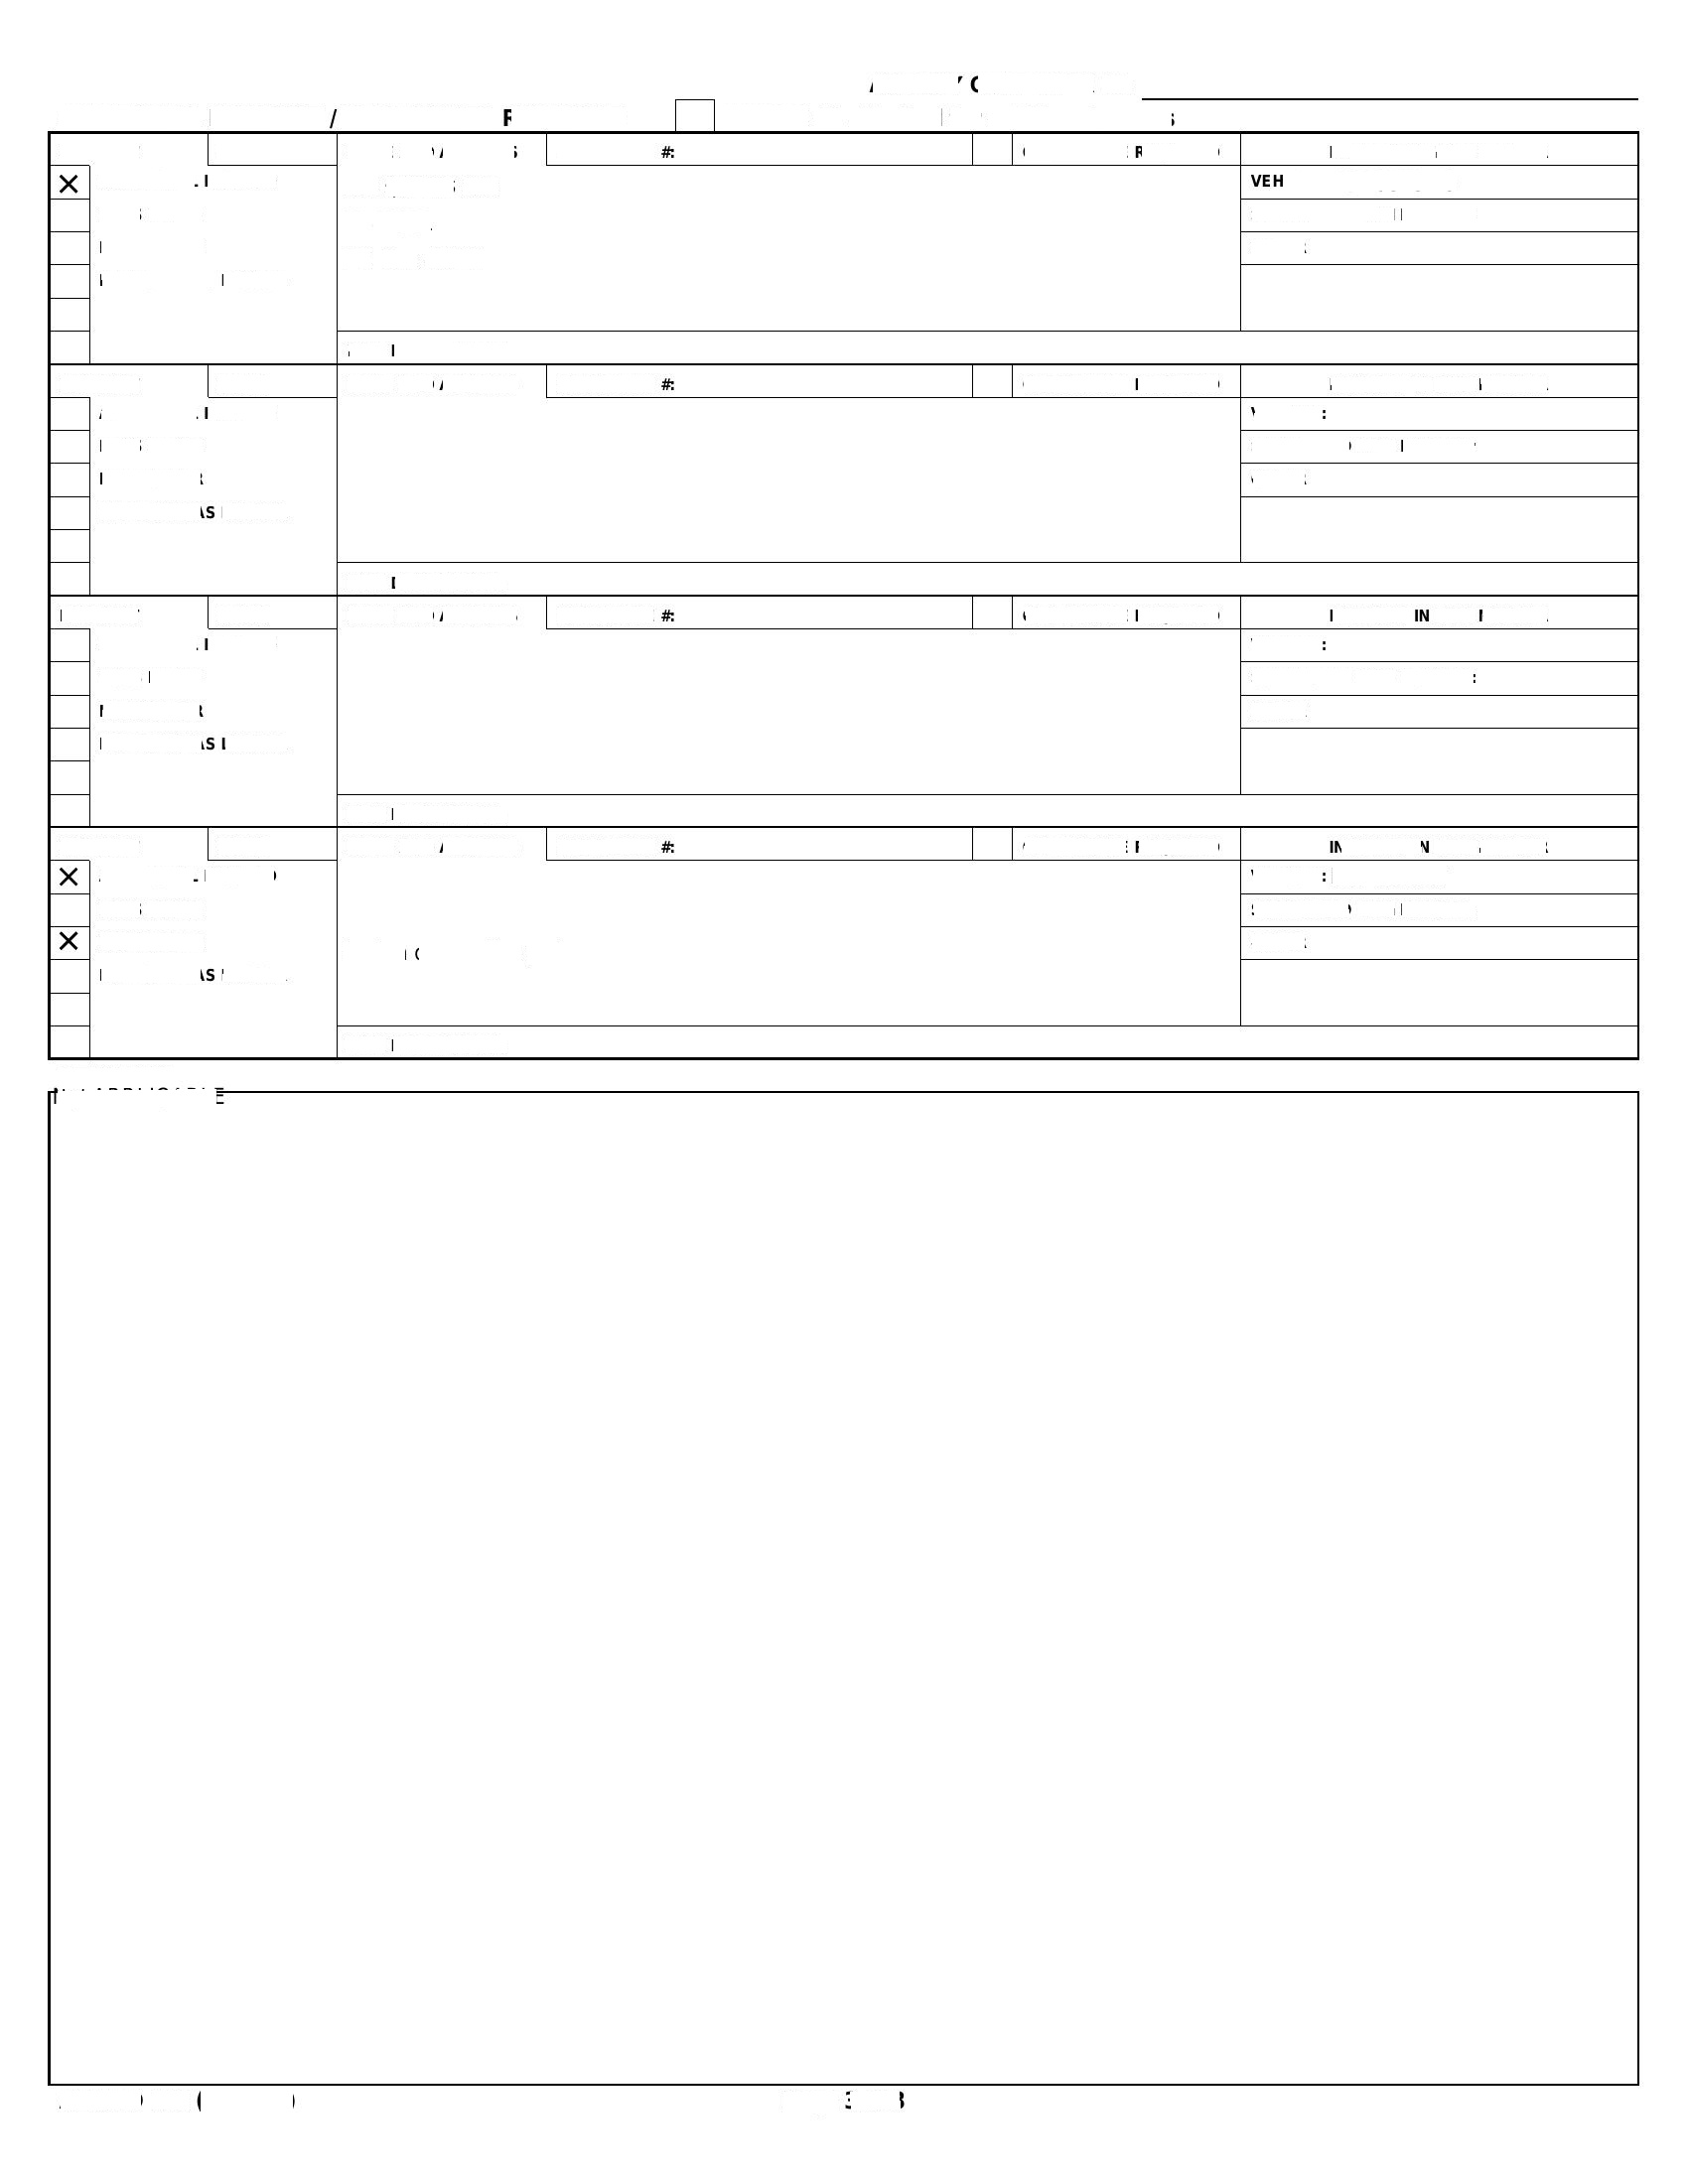

In [71]:
# img = cv2.imread(file_ready_for_lines_detection)
img = cv2.imread(input_file)
orig_img = cv2.imread(input_file)
line_only_img = cv2.imread(file_ready_for_lines_detection)

resize = scale_img(orig_img,0.25,0.25)

display(Image.fromarray(img))


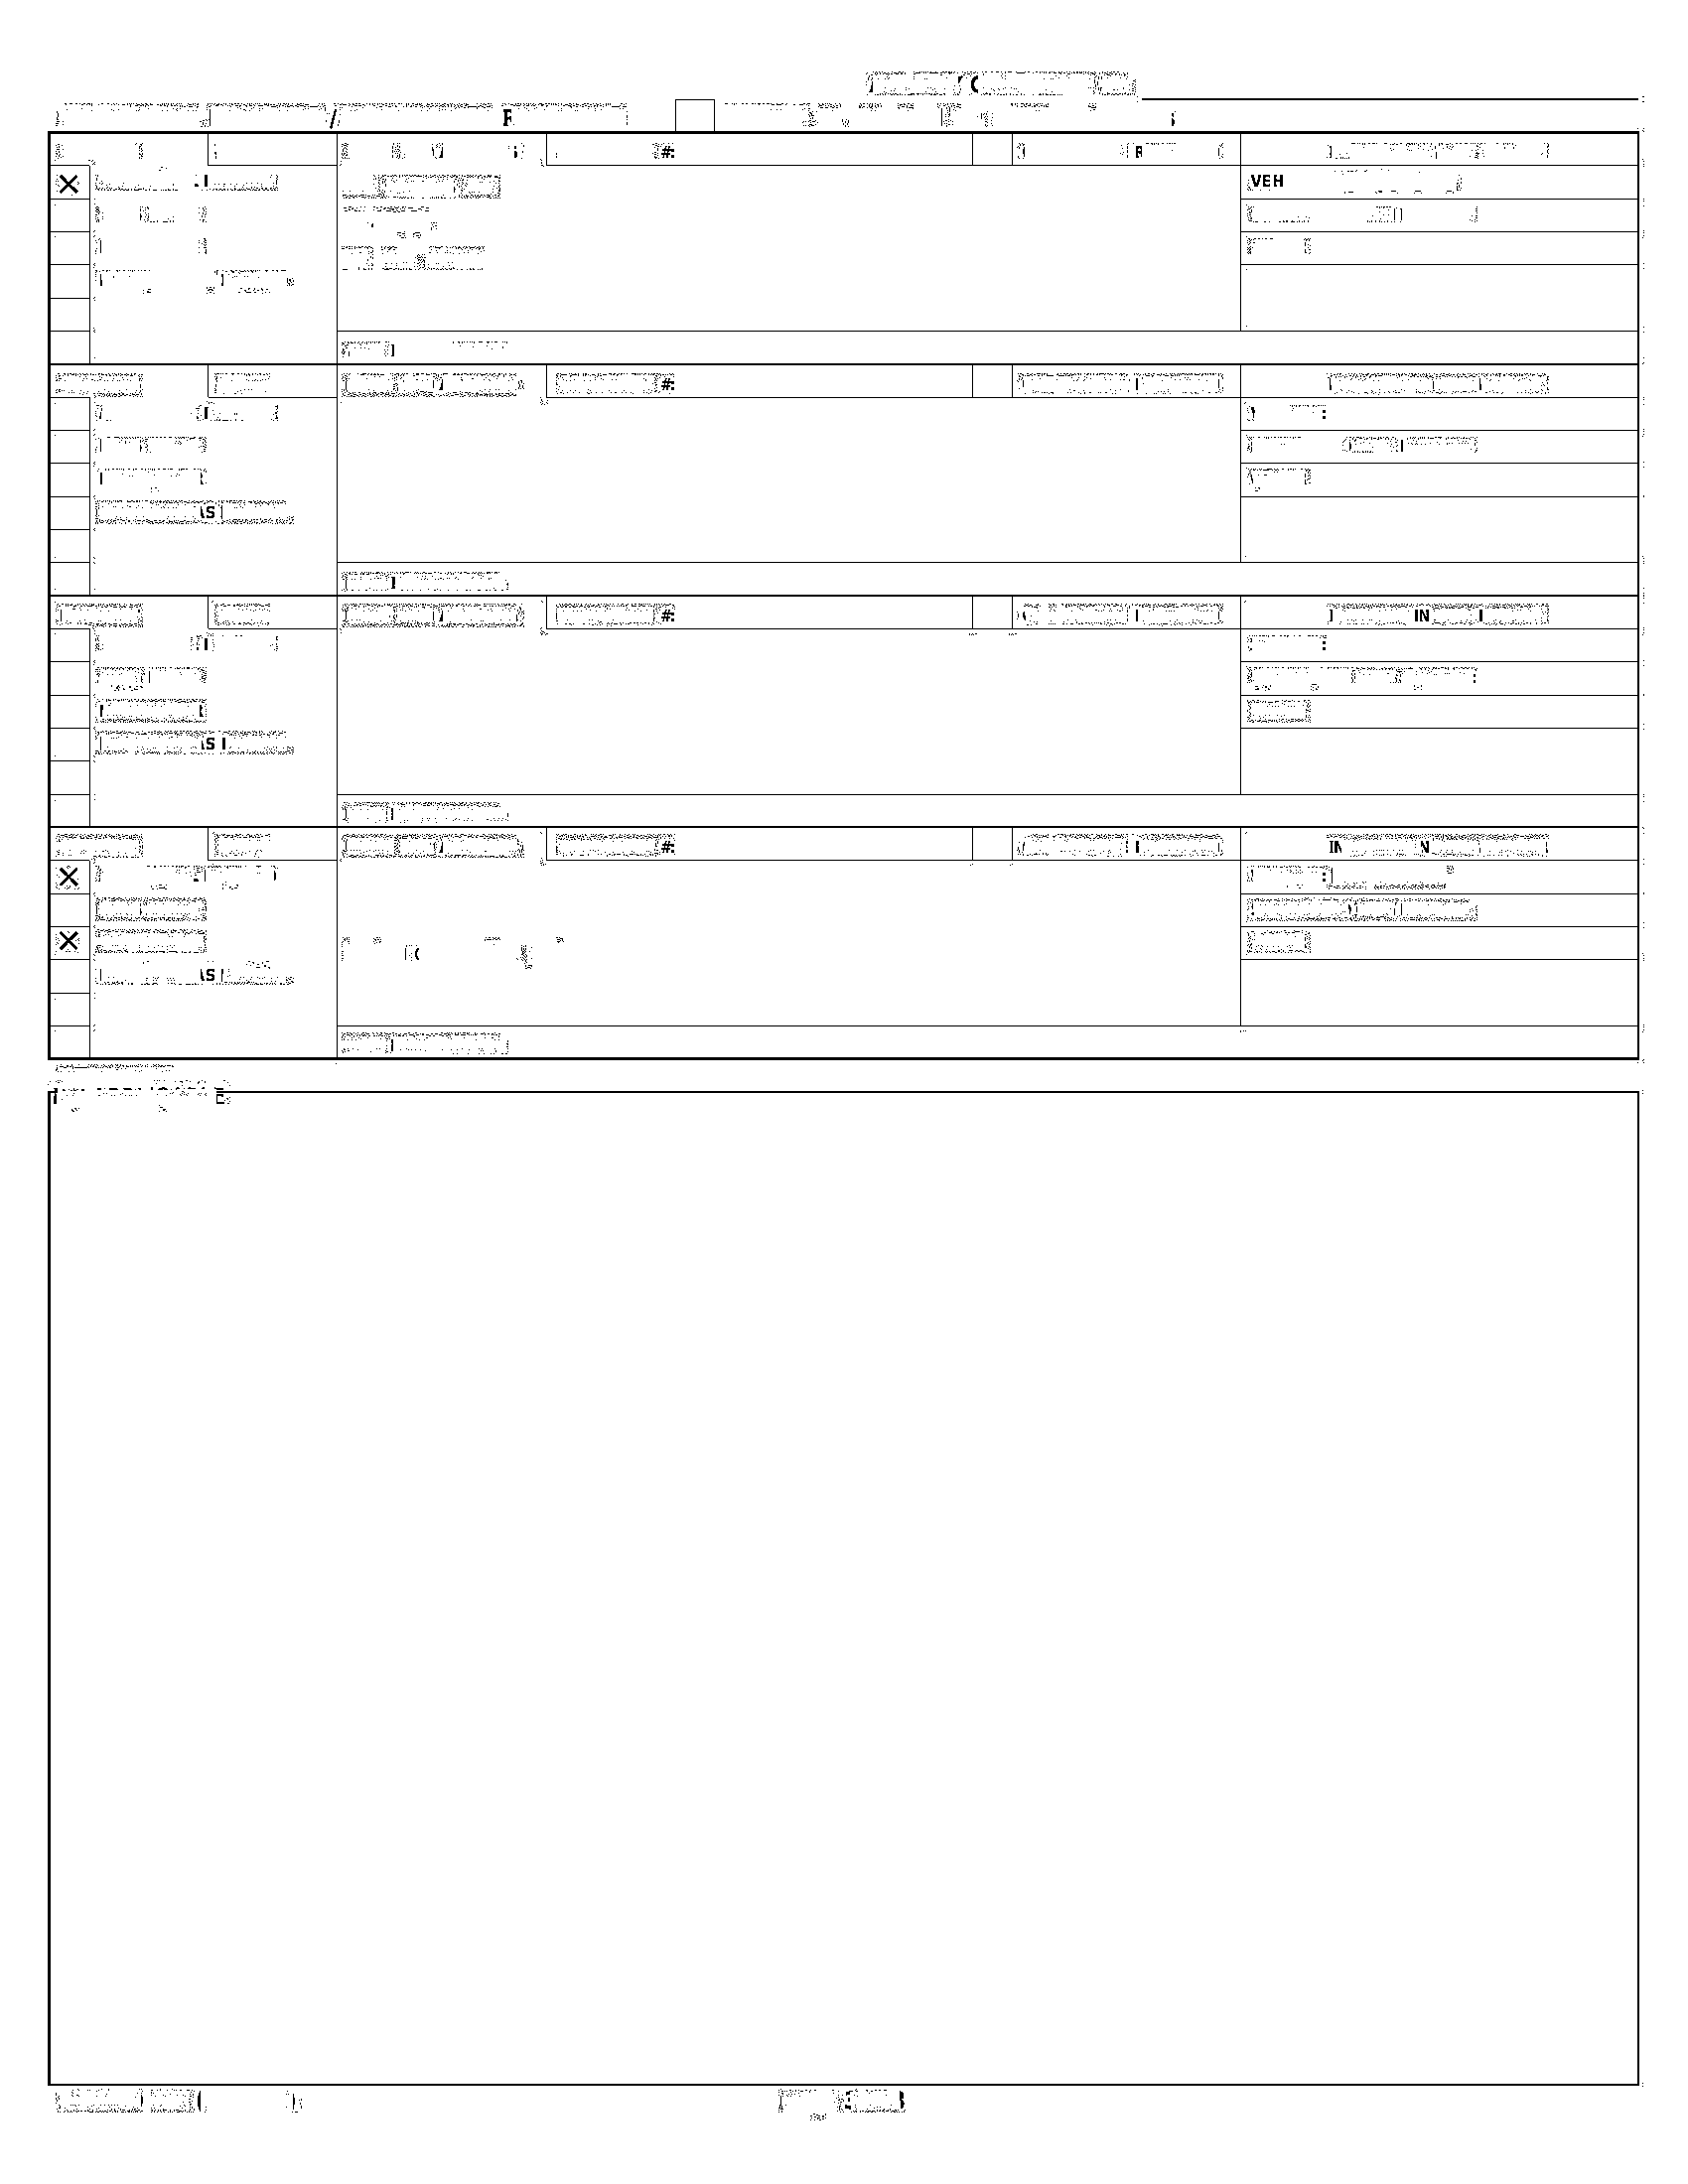

In [72]:
thres = get_image_adaptive_threshold(img)
display(Image.fromarray(thres))

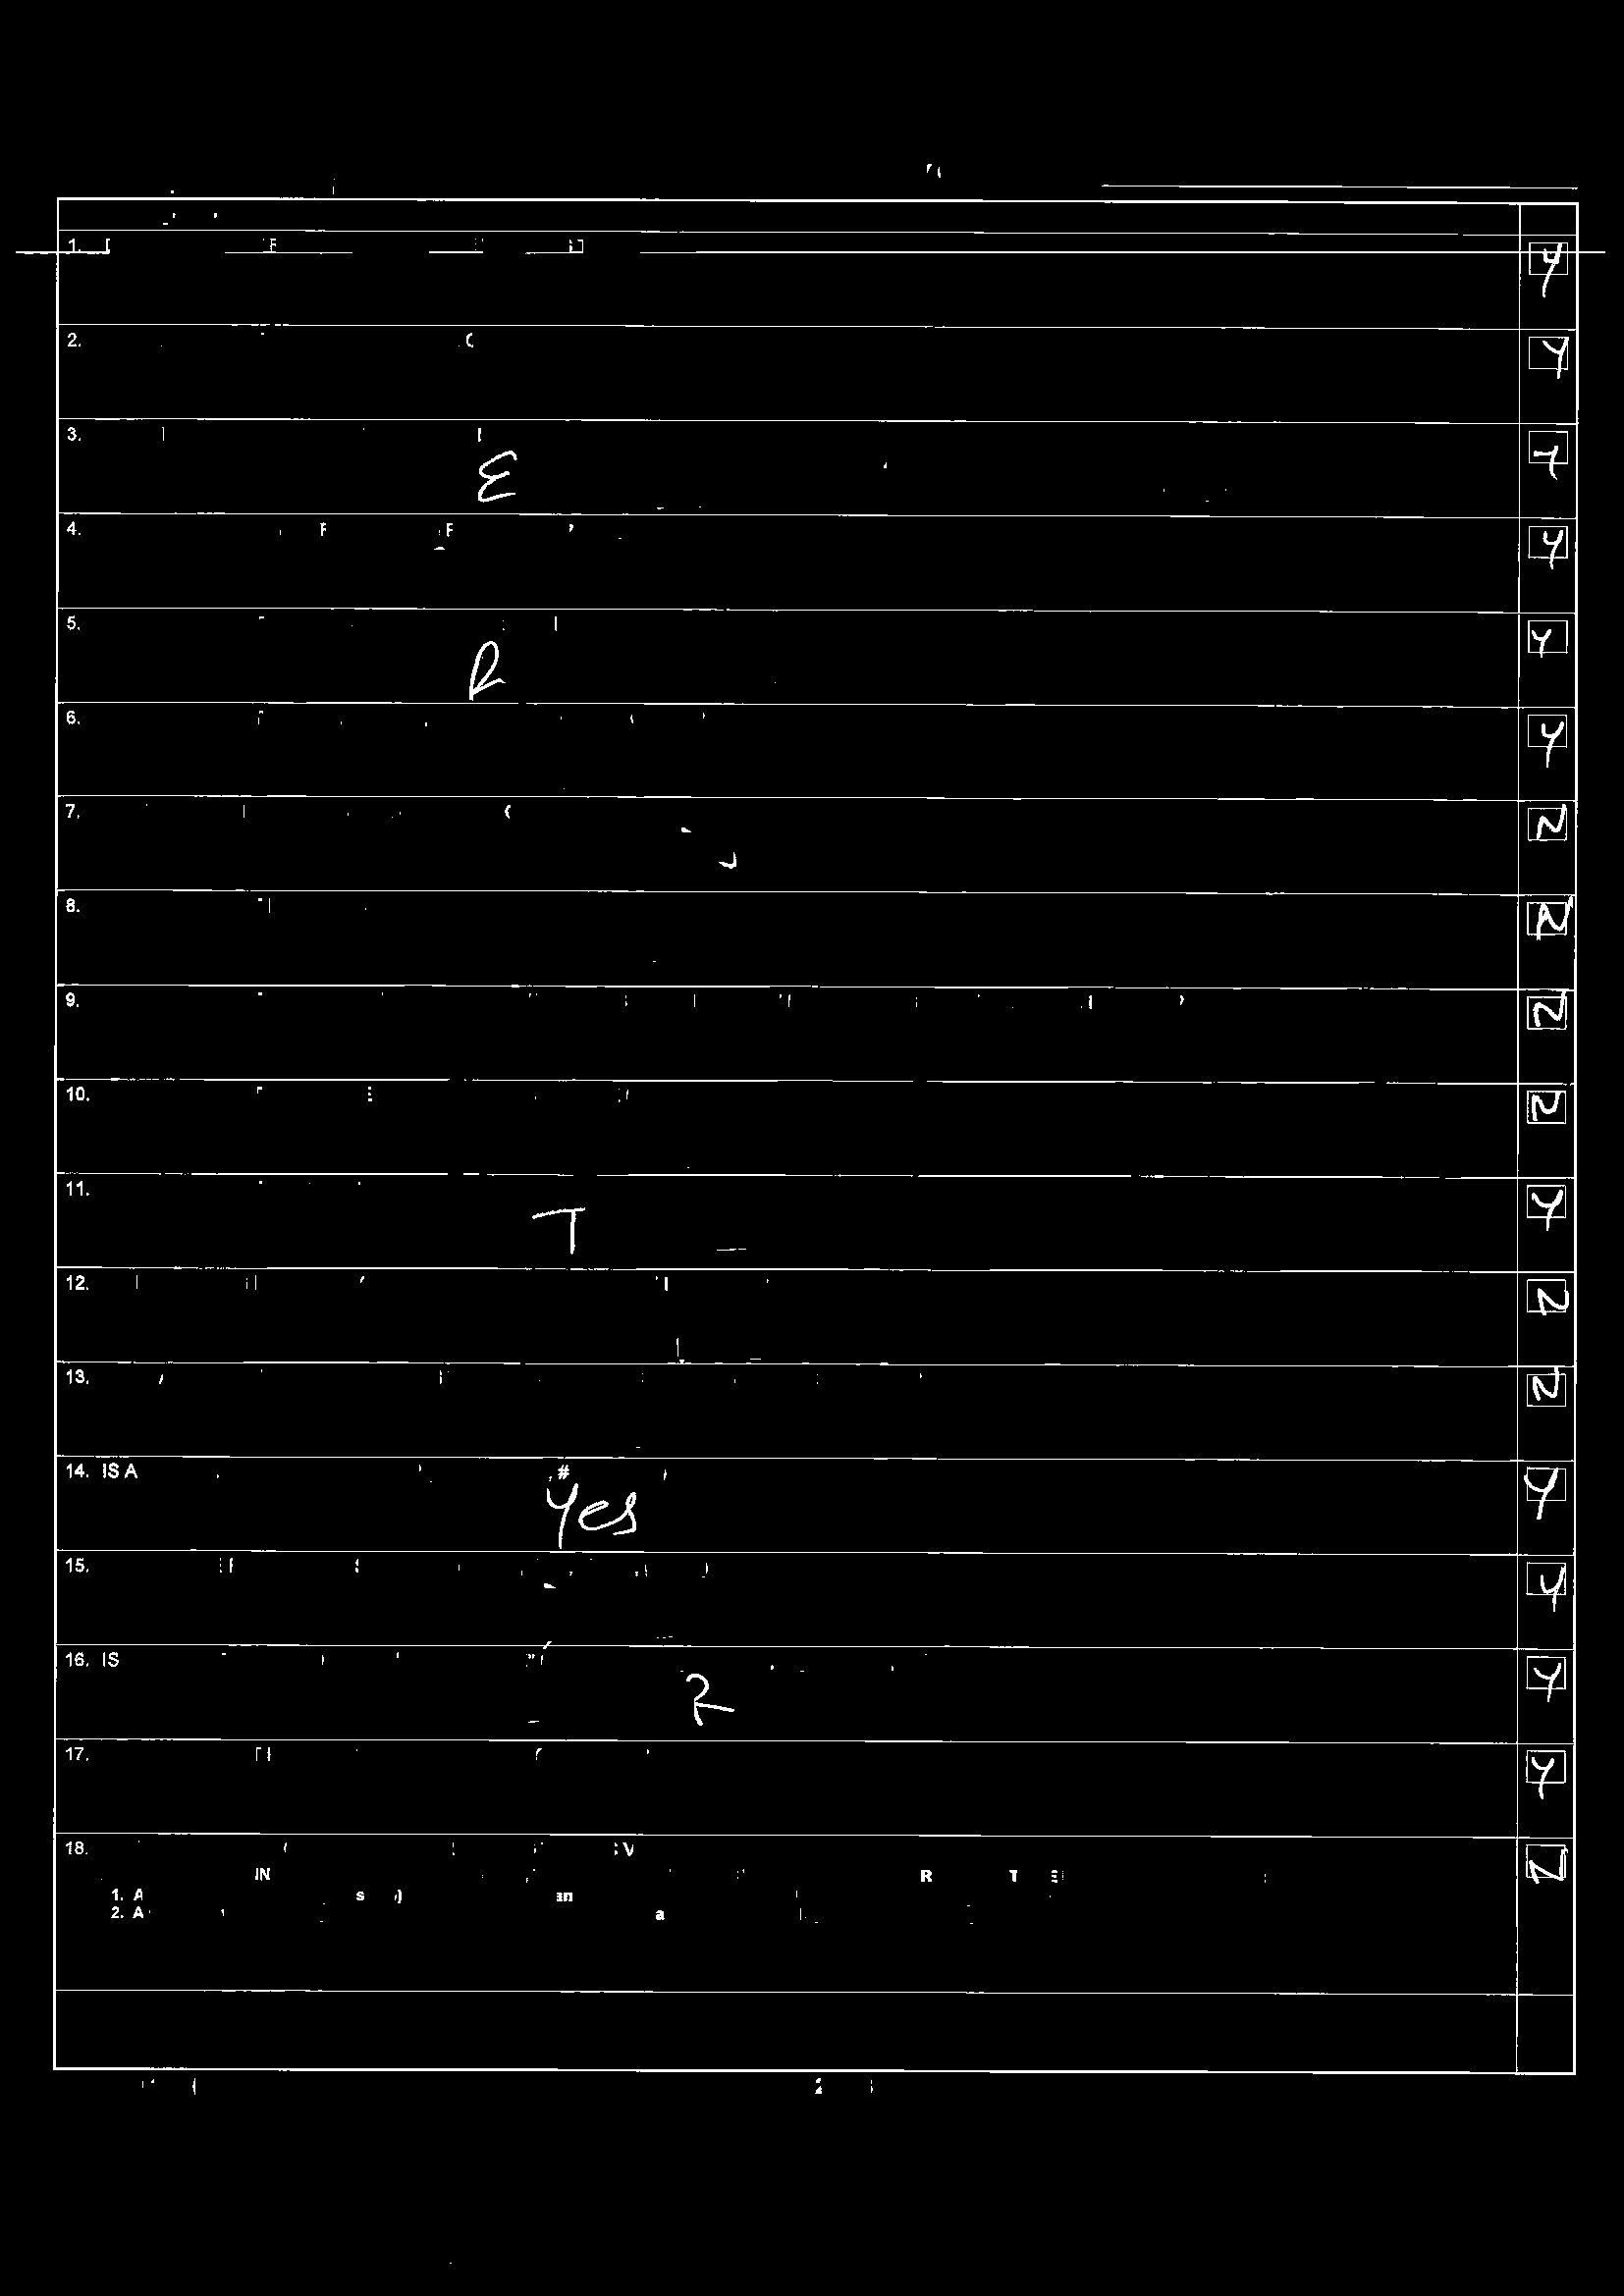

In [53]:
img_out_g_i_t = get_image_threshold_bin(img)
display(Image.fromarray(img_out_g_i_t))

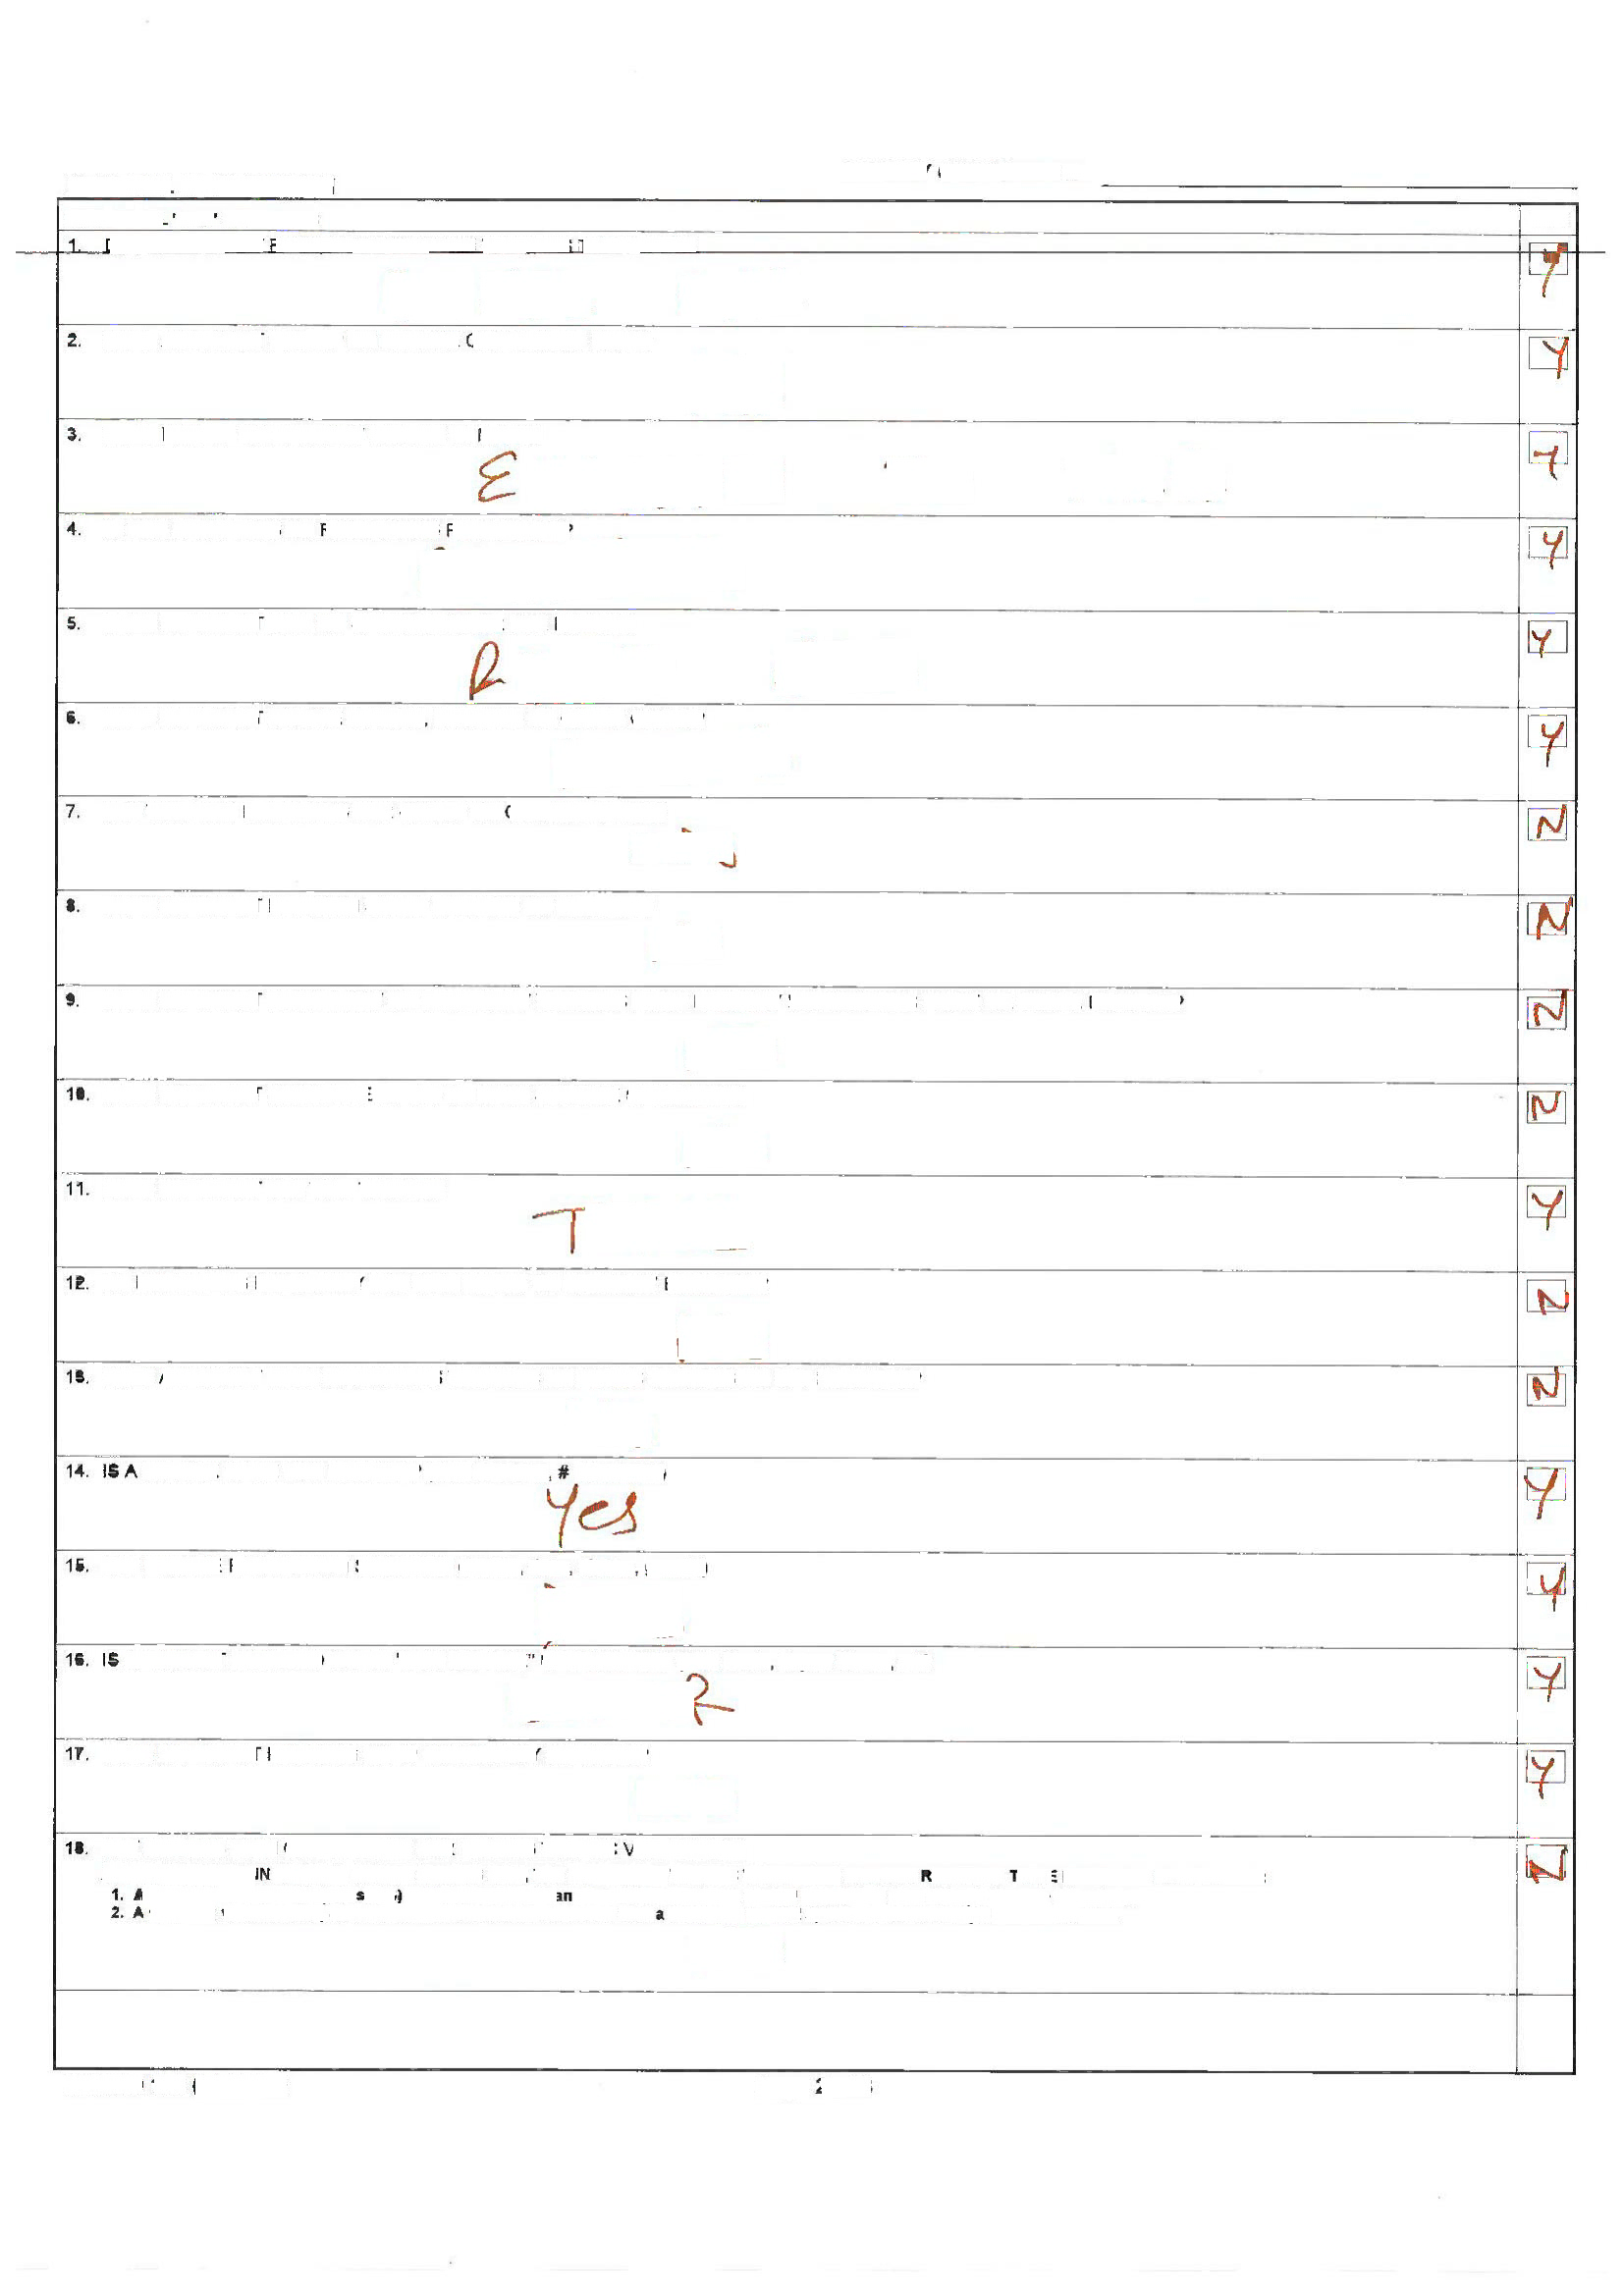

In [50]:
eroded_and_dilated = image_dilate_erode_transform(orig_img)
display(Image.fromarray(eroded_and_dilated))

In [ ]:
corner_points_img = plot_points_on_img(eroded_and_dilated)
display(Image.fromarray(corner_points_img))

In [ ]:
im = draw_countour_names(img)
display(Image.fromarray(im))

In [ ]:
img_out_gap_filled = draw_lines_between_nearest_axis_points(eroded_and_dilated)
display(Image.fromarray(img_out_gap_filled))

In [ ]:
laplacian = apply_laplacian(eroded_and_dilated)
display(Image.fromarray(laplacian))

detected rectangles = 7550


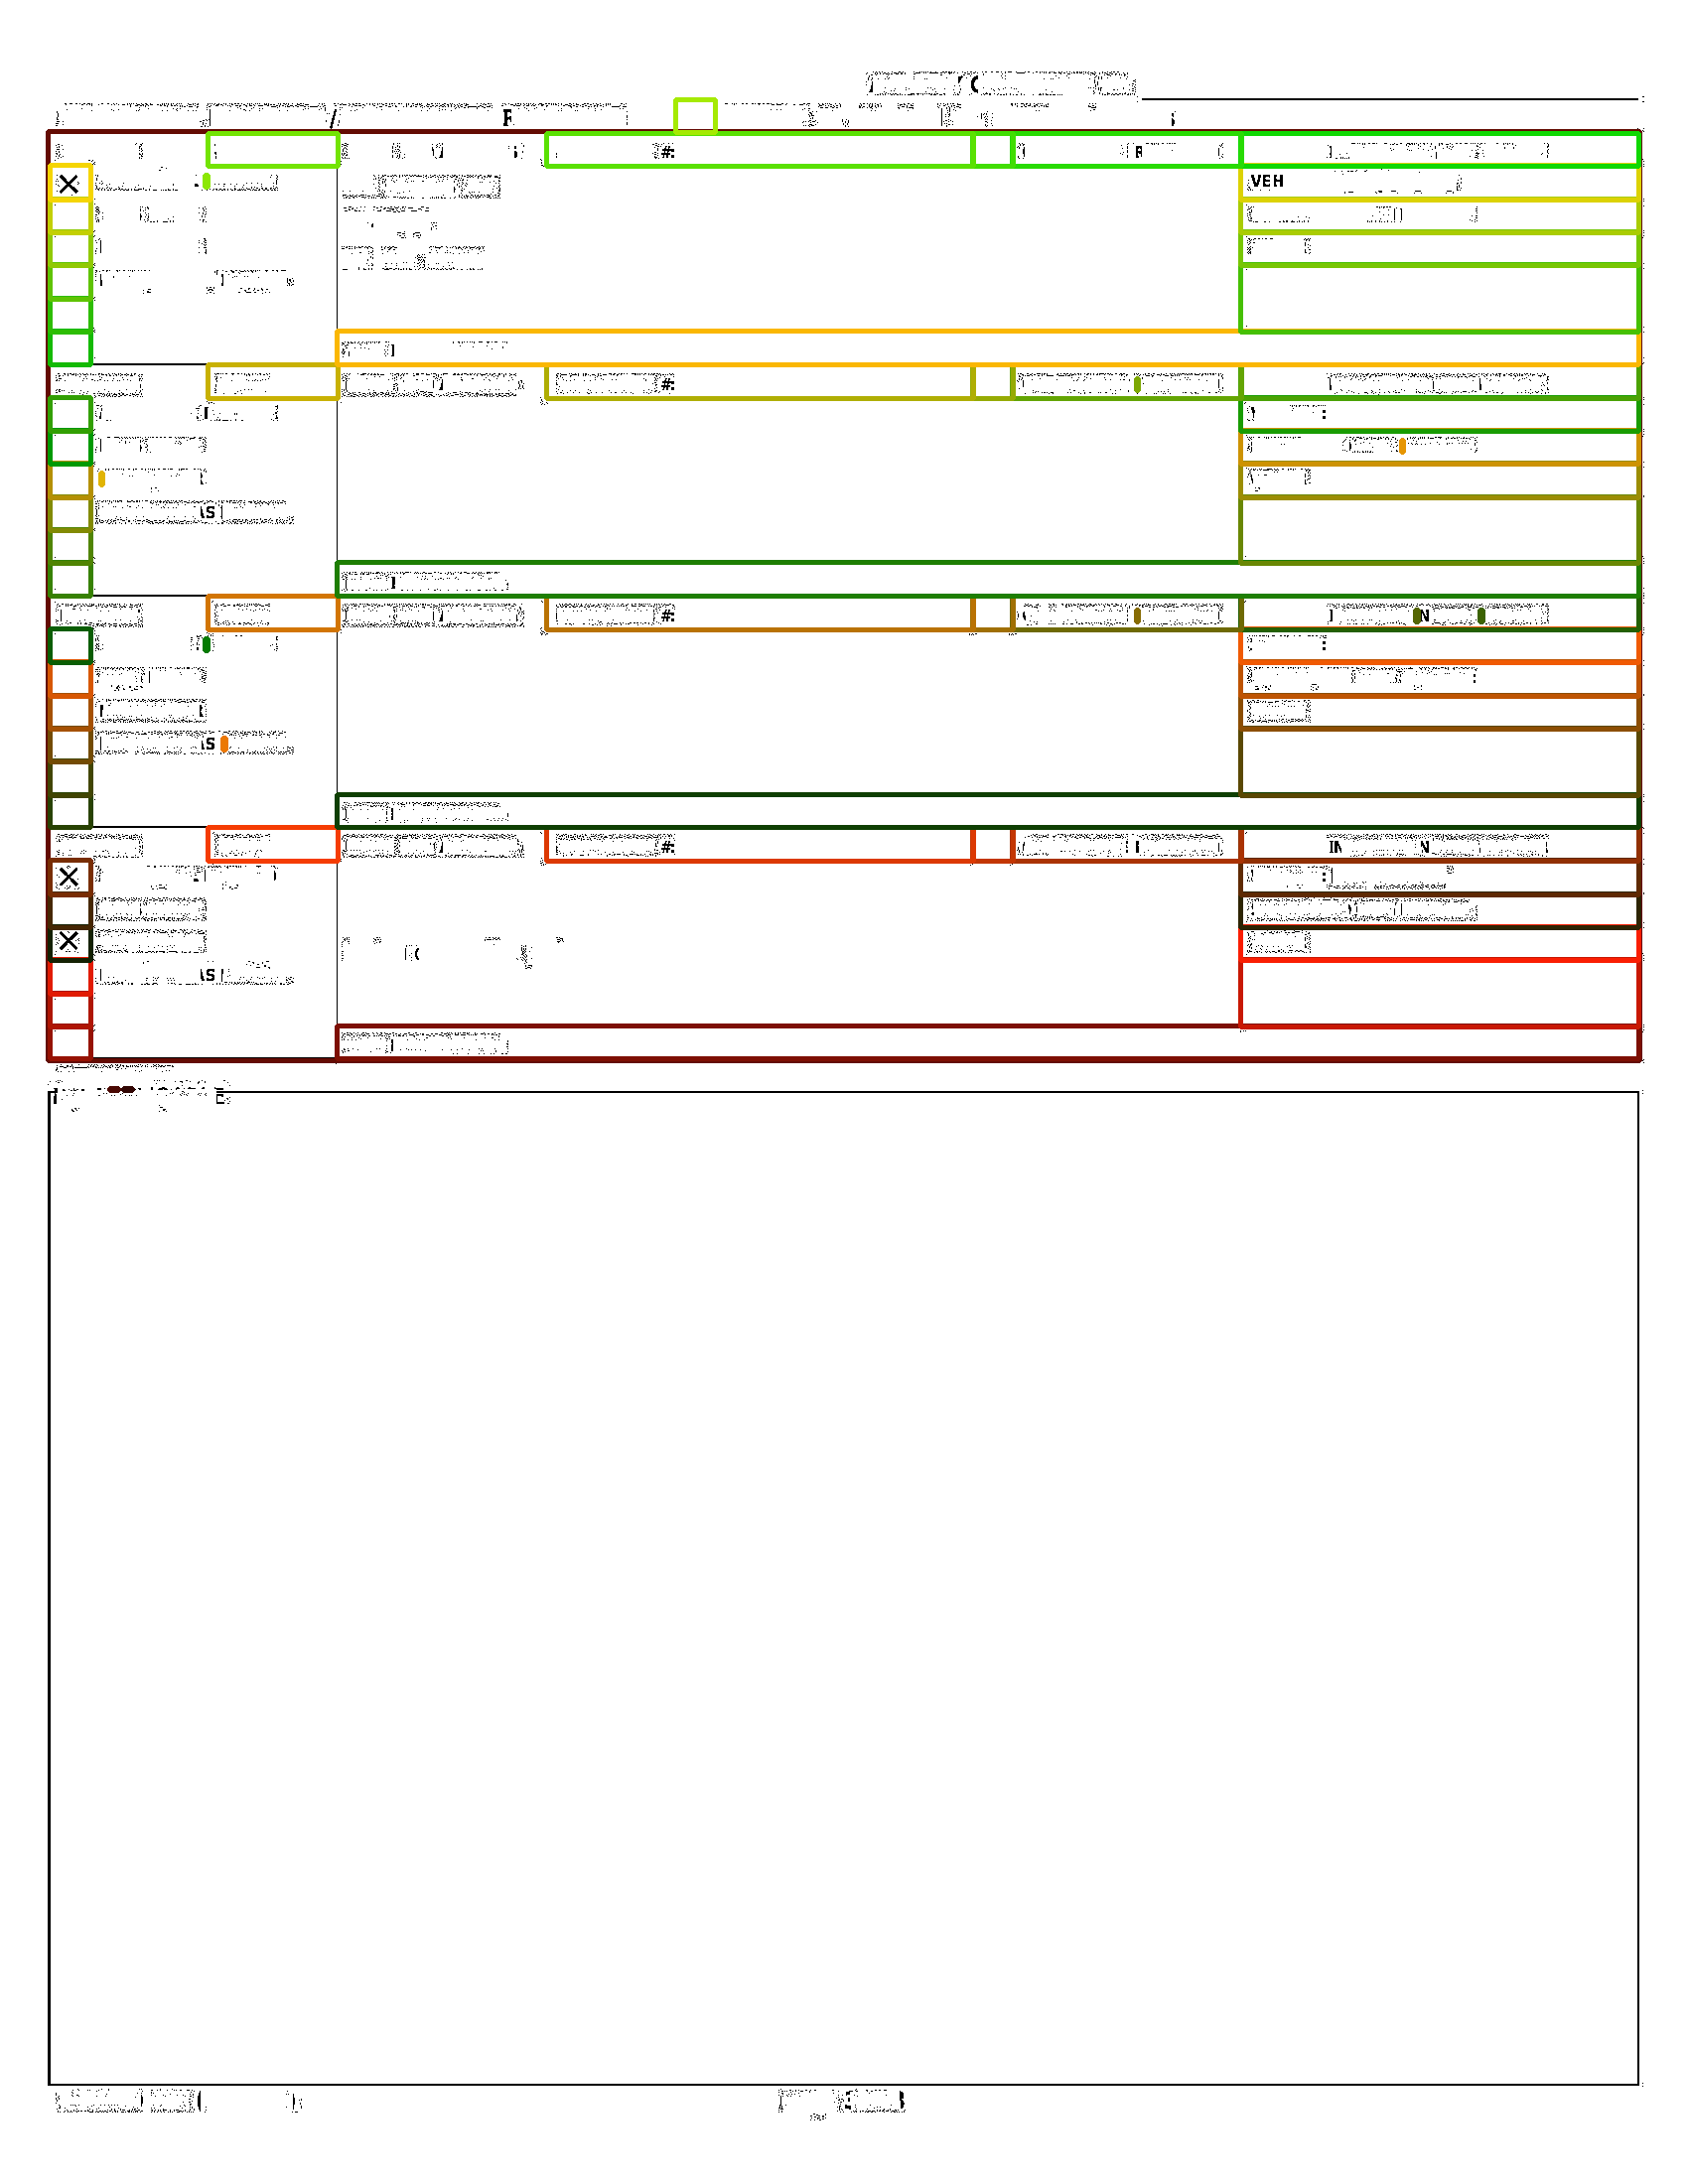

In [77]:
rect_img = draw_rectangles_on_image(thres, True)
display(Image.fromarray(rect_img))

# points = cv2.findNonZero(eroded_and_dilated)
# rects = cv2.boundingRect(points)
# pp.pprint(rects)
# color = (252, 3, 3)
# for rect in rects:
#     if (rect != None):
#         cv2.rectangle(eroded_and_dilated, (int(rect[0]), int(rect[1])), (int(rect[0]+rect[2]), int(rect[1]+rect[3])), color, 3) 

In [ ]:
def preprocess_file(img, runInv=True):
    
    if (runInv):
        img_out_g_i_t = get_image_threshold_bin(img)
    else:
        img_out_g_i_t = img 
    eroded_and_dilated = image_dilate_erode_transform(img_out_g_i_t)
    img_out_gap_filled = draw_lines_between_nearest_axis_points(eroded_and_dilated)
    rect_img = draw_rectangles_on_image(img_out_gap_filled, False)
    
    return rect_img

In [ ]:
stg1_img = preprocess_file(img)
display(Image.fromarray(get_gray(stg1_img)))

In [ ]:
stg2_img = preprocess_file(get_gray(stg1_img), runInv=True)
display(Image.fromarray(get_gray(stg2_img)))

In [ ]:
stg3_img = preprocess_file(get_gray(stg2_img), runInv=True)
display(Image.fromarray(stg3_img))

## functions

In [6]:
def get_color(src):
    # [gray]
    # Transform source image to gray if it is not already
    if len(src.shape) == 2:
        color = cv2.cvtColor(src,cv2.COLOR_GRAY2RGB)
    else:
        color = src.copy()
    
    return color

In [7]:
def get_gray(src):
    # [gray]
    # Transform source image to gray if it is not already
    if len(src.shape) != 2:
        gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    else:
        gray = src.copy()
    
    return gray

In [63]:
def get_image_adaptive_threshold(img):
    
    gray = get_gray(img)
    adptthres = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)    
    
    return adptthres

In [59]:
def get_image_threshold_bin(img):
    
    gray = get_gray(img)
    (thresh, img_gray) = cv2.threshold(gray, 125,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bin = 255-img_gray
    
    return img_bin
    

In [9]:
import math

def distance_between_points(pt1, pt2):
    if (len(pt1) > 2):
        (x1, y1, z), (x2, y2, z) = pt1, pt2
    else:
        (x1, y1), (x2, y2) = pt1, pt2    
    dist = math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
    return dist

In [10]:

def get_line_intersection_points(img):
    
#     thresh = 10
#     gray = get_gray(img)
#     gray = np.float32(gray)
#     dst = cv2.cornerHarris(gray,5,3,0.04)
#     ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
#     dst = np.uint8(dst)
#     ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
#     coordinates = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
    
    thresh = 15
    gray_img = get_gray(img)        
    dst = cv2.cornerHarris(gray_img,2,3,0.04)     
    mask = np.zeros_like(img)
    mask[dst>0.05*dst.max()]=[0,0,255]
    coordinates = np.argwhere(mask)
        
    coor_list = [list(map(int,l.tolist())) for l in list(coordinates)]
    coor_tuples = [tuple(l) for l in coor_list]
            
    save_tuples = coor_tuples.copy()
    coor_tuples_copy = coor_tuples

    i = 1
    for pt1 in coor_tuples:

#         print(' I :', i)
        for pt2  in coor_tuples[i::1]:        
            dist = distance_between_points(pt1, pt2)
#             print(pt1, pt2, dist)
            if (dist > thresh):
                break;

#             print('cnt = ' +str(i)+ ', Distance :', dist)
            if(dist < thresh):
                coor_tuples_copy.remove(pt2)      

        i+=1
    
    print("Total points original = "+str(len(save_tuples)))
    print("Total points after = "+str(len(coor_tuples_copy)))
    print("Total removed = "+str(len(save_tuples) - len(coor_tuples_copy)))

    
    return coor_tuples


In [11]:
def plot_points_on_img(img, coordinate_tuples=None):
    
    plt_img = get_color(img)
    if (coordinate_tuples == None):
        coordinate_tuples = get_line_intersection_points(plt_img)
    
    for coord in coordinate_tuples:
        if (len(coord) == 3):
            y,x,_ = coord
        else:
            x,y = coord

        cv2.circle(plt_img, tuple([x,y]),5, (0,128,128), 0)
#         for point in [tuple([x,y])]:
        
    
    return plt_img
    

In [12]:
def draw_lines_between_nearest_axis_points(img):

    plt_img = get_color(img)
    
    coordinate_tuples = get_line_intersection_points(plt_img) 
    if (len(coordinate_tuples[0]) == 3):
        x_tuples = [tuple([x,y]) for y,x,_ in coordinate_tuples]
        y_tuples = [tuple([y,x]) for y,x,_ in coordinate_tuples]
    else:
        x_tuples = [tuple([x,y]) for x,y in coordinate_tuples]
        y_tuples = [tuple([y,x]) for x,y in coordinate_tuples]
    

    x_dict = {k:tuple(x[1] for x in v) for k,v in it.groupby(sorted(x_tuples), key=lambda x: x[0])}
    y_dict = {k:tuple(x[1] for x in v) for k,v in it.groupby(sorted(y_tuples), key=lambda x: x[0])}
    
    ## smoothen the y plane
    smooth_gap_x = 2
    smooth_gap_y = 10
    
    y_dict_copy = y_dict            
    keyList=sorted(y_dict.keys())
    keyList_copy = keyList    
    for i1,v1 in enumerate(keyList):
        for i2,v2 in enumerate(keyList_copy[i1+1::1]):        
#             print("processing..."+str(i1)+" - "+str(v1) +" .... with ..."+str(i2)+"-"+str(v2))
            if (abs(v1 - v2) < smooth_gap_y):
                y_dict[v1] = (y_dict[v1] + y_dict[v2])                
                del y_dict[v2]
                keyList_copy.remove(v2)                        
    
    ## smoothen the x plane
    
    x_dict_copy = x_dict            
    keyList=sorted(x_dict.keys())
    keyList_copy = keyList    
    for i1,v1 in enumerate(keyList):
        for i2,v2 in enumerate(keyList_copy[i1+1::1]):        
#             print("processing..."+str(i1)+" - "+str(v1) +" .... with ..."+str(i2)+"-"+str(v2))
            if (abs(v1 - v2) < smooth_gap_x):
                x_dict[v1] = (x_dict[v1] + x_dict[v2])                
                del x_dict[v2]
                keyList_copy.remove(v2)                        
    
    line_drawn = []
    only_point_img = get_color(img)    
    gap_thres = 30
    for key in y_dict:        
        x_vals = x_vals_cpy =  y_dict[key]
        i = 0
        for x1 in x_vals:        
            i +=1
            for x2 in x_vals_cpy[i::1]:
                pt1 = (x1,key,0)
                pt2 = (x2,key,0)            
                dist = distance_between_points(pt1, pt2)
                if dist < gap_thres and ((pt1,pt2) not in line_drawn):
                    line_drawn.append((pt1,pt2))
                    cv2.line(only_point_img,(pt1[0],pt1[1]),(pt2[0],pt2[1]), (255, 255, 255), thickness=3, lineType=8)

    line_drawn = []
    for key in x_dict:        
        y_vals = y_vals_cpy =  x_dict[key]
        i = 0
        for y1 in y_vals:        
            i +=1
            for y2 in y_vals_cpy[i::1]:
                pt1 = (key,y1,0)
                pt2 = (key,y2,0)
                dist = distance_between_points(pt1, pt2)
                if dist < gap_thres and ((pt1,pt2) not in line_drawn):
                    line_drawn.append((pt1,pt2))
                    cv2.line(only_point_img,(pt1[0],pt1[1]),(pt2[0],pt2[1]), (58, 168, 50), thickness=2, lineType=8)
    
    return only_point_img



In [13]:
def get_rectangles_in_image(img, strict=True):
    
    id= -1
    MIN_BOUNDED_AREA = 5
    thresh_img = get_image_threshold_bin(get_gray(img))
    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    boundRect = [None]*len(contours)
    overlay_img = get_color(img)
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)    
        if (len(approx)==4 or (not strict)) and (cv2.contourArea(cnt) > MIN_BOUNDED_AREA):
            id += 1
            boundRect[id] = cv2.boundingRect(approx)
    
    print("detected rectangles = "+str(len(boundRect)))
    return boundRect
            
    

In [76]:
def draw_rectangles_on_image(img, strict=True):
    
    overlay_img = get_color(img)
    rectangles = get_rectangles_in_image(overlay_img, strict)
    color = (252, 3, 3)
    id =1
    for rect in rectangles:
#         pp.pprint(rect)
        id += 1
        color = ((25*id) % 255, (3*id) % 255, 3)
        if (rect != None):
            cv2.rectangle(overlay_img, (int(rect[0]), int(rect[1])), (int(rect[0]+rect[2]), int(rect[1]+rect[3])), color, 3) 
   
    return overlay_img


In [15]:
def draw_countour_names(img):
    sd = ShapeDetector()

    original = get_gray(img)
    resized = imutils.resize(original, width=300)
    ratio = img.shape[0]
    thresh = cv2.threshold(original, 60, 255, cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    # loop over the contours
    for c in cnts:
        # compute the center of the contour, then detect the name of the
        # shape using only the contour
        try:
            M = cv2.moments(c)
            cX = int((M["m10"] / M["m00"]) * ratio)
            cY = int((M["m01"] / M["m00"]) * ratio)
            shape = sd.detect(c)
            print(shape)
            # multiply the contour (x, y)-coordinates by the resize ratio,
            # then draw the contours and the name of the shape on the image
            c = c.astype("float")
            c *= ratio
            c = c.astype("int")
            cv2.drawContours(original, [c], -1, (0, 255, 0), 2)
            cv2.putText(original, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (255, 255, 255), 2)
        except Exception as e:
            print("---"+str(e))
            
    
    return original
        

In [16]:
def sort_contours(cnts, method="left-to-right"):
        # initialize the reverse flag and sort index
        reverse = False
        i = 0
    
        # handle if we need to sort in reverse
        if method == "right-to-left" or method == "bottom-to-top":
            reverse = True
    
        # the x-coordinate of the bounding box
        if method == "top-to-bottom" or method == "bottom-to-top":
            i = 1
    
        # construct the list of bounding boxes and sort them from top to
        # bottom
        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
            key=lambda b:b[1][i], reverse=reverse))
    
        # return the list of sorted contours and bounding boxes
        return (cnts, boundingBoxes)

In [17]:
def sort_poly(p):
    min_axis = np.argmin(np.sum(p, axis=1))
    p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
    if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
        return p
    else:
        return p[[0, 3, 2, 1]]

In [18]:
def canny_blur(img):        
    blurred = cv2.GaussianBlur(img, (3, 3), 10)
    canny = auto_canny(blurred)
    return canny

In [57]:
def super_dilate(img, iterations=5):

    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))

    horizontal_lines_img = cv2.dilate(img, hori_kernel, iterations=5)
    vertical_lines_img = cv2.dilate(img, verticle_kernel, iterations=5)

    img_final_bin = vertical_lines_img | horizontal_lines_img
    
    return img_final_bin

In [19]:
def image_dilate_erode_transform(img_bin):

    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))

    horizontal_lines_img = cv2.erode(img_bin, hori_kernel, iterations=5)
    horizontal_lines_img = cv2.dilate(horizontal_lines_img, hori_kernel, iterations=5)
    # morpho close vertical
    vertical_lines_img = cv2.erode(img_bin, verticle_kernel, iterations=5)
    vertical_lines_img = cv2.dilate(vertical_lines_img, verticle_kernel, iterations=5)

    img_final_bin = vertical_lines_img | horizontal_lines_img
    
    return img_final_bin

In [20]:
import matplotlib as mpl

def plt_show(img, cmap='gray'):
    
    dpi = mpl.rcParams['figure.dpi']
    height, width = img.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(img, cmap)

    plt.show()

In [21]:
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
 
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
 
	# return the edged image
	return edged

In [22]:
def smoothen_countour(img):
    smoothened = []    
    original_img = img.copy()
    ret,thresh_img = cv2.threshold(get_gray(img),127,255,cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(thresh_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        x,y = contour.T
        # Convert from numpy arrays to normal arrays
        x = x.tolist()[0]
        y = y.tolist()[0]
        # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splprep.html
        tck, u = splprep([x,y], u=None, s=1.0, per=1)
        # https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linspace.html
        u_new = np.linspace(u.min(), u.max(), 25)
        # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splev.html
        x_new, y_new = splev(u_new, tck, der=0)
        # Convert it back to numpy format for opencv to be able to display it
        res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
        smoothened.append(np.asarray(res_array, dtype=np.int32))

    # Overlay the smoothed contours on the original image
    cv2.drawContours(original_img, smoothened, -1, (255,255,255), 2)
    
    return original_img

In [23]:
def apply_laplacian(img):
    
    out_img = img.copy()
    laplacian = cv2.Laplacian(img,cv2.CV_8UC1) # Laplacian OR
    edges = cv2.Canny(img,80,10,apertureSize = 3) # canny Edge OR
    # Output dtype = cv2.CV_8U # Sobel
    sobelx8u = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=5)
    # Output dtype = cv2.CV_64F. Then take its absolute and convert to cv2.CV_8U
    sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    abs_sobel64f = np.absolute(sobelx64f)
    sobel_8u = np.uint8(abs_sobel64f)

    # Hough's Probabilistic Line Transform 
    minLineLength = 900
    maxLineGap = 100
    lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(out_img,(x1,y1),(x2,y2),(255,255,255),2)
            
    return out_img

In [24]:
# import the necessary packages

class ShapeDetector:
    def __init__(self):
        pass

    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"

        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)

            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"

        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"

        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"

        # return the nam

In [40]:
def scale_img(oriimg, fx, fy):
    
    img = cv2.resize(oriimg,None,fx=fx,fy=fy,interpolation=cv2.INTER_CUBIC)
    return img